In [18]:
import statsmodels
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf
import h5py
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from multiprocess import Pool

In [2]:
f = h5py.File("/Users/danielzeiberg/Documents/Human3.6/Processed/all_2D.h5")

In [3]:
f["instances"].shape

(839, 1269, 16, 2)

In [124]:
def do(index = None, subject=None, action=None, subaction=None, camera=None, limit=10000, shouldPlot=True, lastSignificant=True):
    if shouldPlot:
        fig, axes = plt.subplots(32, 1)
        fig.set_size_inches(16, 256)
        plt.subplots_adjust(hspace=.90)
    if index:
        inst = index
    else:
        indices = []
        subjectindices = []
        actionindices = []
        subactionindices = []
        cameraindices = []
        for i in range(f["instances"].shape[0]):
            if subject != None and f["subjects"][i] == subject:
                subjectindices.append(i)
            if action != None and f["actions"][i] == action:
                actionindices.append(i)
            if subaction != None and f["subactions"][i] == subaction:
                subactionindices.append(i)
            if camera != None and f["cameras"][i] == camera:
                cameraindices.append(i)
        if not subject and not action and not subaction and not camera:
            indices = range(f["instances"].shape[0])
        elif subject != None and not len(indices):
            indices = subjectindices
        elif action != None:
            if not len(indices):
                indices = actionindices
            else:
                indices = set(indices).intersection(actionindices)
        elif subaction != None:
            if not len(indices):
                indices = subactionindices
            else:
                indices = set(indices).intersection(subactionindices)
        elif camera != None:
            if not len(indices):
                indices = cameraindices
            else:
                indices = set(indices).intersection(camera)
        inst = np.random.choice(indices)
    dat = f["instances"][inst]
    def plotVals(i,j):
        num = min(f["lengths"][inst], limit)
        corr= dat[:num,i,j]
        if shouldPlot:
            plot_acf(corr,
                        title="Autocorrelation S: {} A: {} SA: {} C: {} sensor({},{})".format(f["subjects"][inst],
                                                                                              f["actions"][inst],
                                                                                              f["subactions"][inst],
                                                                                              f["cameras"][inst],
                                                                                              i,j),
                        lags=range(1,len(corr)),
                        ax = axes[i*2+j],
                        alpha=None
                        )
        acfVals,confInt = acf(corr, nlags=len(corr)-1, alpha=0.05)
#         def sse(lag):
#             return 1.96 / np.sqrt(corr.shape[0] - lag)
#         SE = np.array([sse(lag) for lag in range(len(corr))])
        maxLag = 0
        for idx,lag in enumerate(range(len(corr))):
            if acfVals[idx] < confInt[idx,0]-acfVals[idx] or acfVals[idx] > confInt[idx,1]-acfVals[idx]:
                color="green"
                if lastSignificant:
                    maxLag = idx
            else:
                if not lastSignificant:
                    if maxLag == 0:
                        maxLag = idx - 1
                color="red"
            if shouldPlot:
                axes[2*i+j].scatter(idx, acfVals[idx], color=color, zorder=3)
        if shouldPlot:
            axes[2*i+j].fill_between(np.arange(len(corr)), confInt[:,0]-acfVals, confInt[:,1]-acfVals, alpha=0.25)
            axes[2*i+j].set_xticks(np.arange(0,len(corr), len(corr)//20))
            axes[2*i+j].set_xlabel("lag")
            axes[2*i+j].set_ylabel("Autocorrelation")
            axes[2*i+j].set_xticklabels(np.arange(0,len(corr), len(corr)//20), rotation=45)
        return maxLag
    maxLags = []
    for i in range(16):
        for j in range(2):
            maxLags.append(plotVals(i,j))
    print(np.mean(maxLags))
    return np.mean(maxLags)

18.1875


18.1875

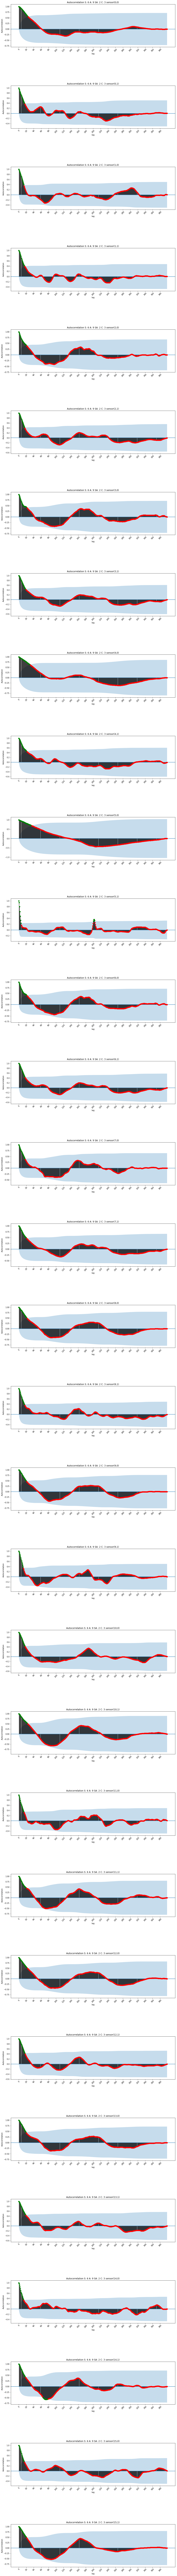

In [128]:
do(lastSignificant=False)

In [125]:
maxLags = [do(index=i, shouldPlot=False, lastSignificant=False) for i in range(f["instances"].shape[0])]

10.03125
10.71875
11.25
11.8125
12.8125
13.4375
13.84375
12.53125
23.03125
19.3125
21.875
19.125
31.21875
23.125
24.71875
29.5
22.0
20.96875
23.625
19.1875
25.8125
23.90625
26.9375
21.9375
10.875
8.78125
9.03125
11.40625
8.96875
8.03125
8.28125
9.125
25.375
24.0
26.6875
22.3125
23.8125
19.625
23.6875
20.15625
9.84375
9.65625
9.53125
9.71875
9.59375
8.59375
8.9375
9.125
10.875
8.28125
10.6875
11.65625
12.875
12.125
12.375
13.6875
20.78125
21.09375
20.0625
21.0
20.0
18.78125
20.1875
18.875
20.75
23.375
20.90625
25.09375
22.84375
22.21875
22.875
22.65625
32.875
32.03125
34.90625
27.875
31.0625
33.25
34.5625
28.28125
12.71875
12.0
12.0
12.78125
12.375
11.375
11.5
12.78125
12.15625
11.84375
12.21875
10.5625
14.375
14.875
12.6875
13.875
16.25
14.75
15.9375
14.9375
14.5625
15.90625
14.40625
15.90625
15.3125
14.0
15.4375
15.5
16.34375
15.03125
15.9375
16.0625
11.09375
10.5
11.0625
10.3125
10.46875
9.84375
9.5625
9.40625
38.1875
37.96875
37.875
38.75
13.15625
13.0
13.25
12.9375
33.6875
31.03125

Text(0.5,1,'lag based off first insignificant, mean: 18.87544696066746, median: 16.1875 std: 9.202389906158613, min: 6.625, max: 71.4375')

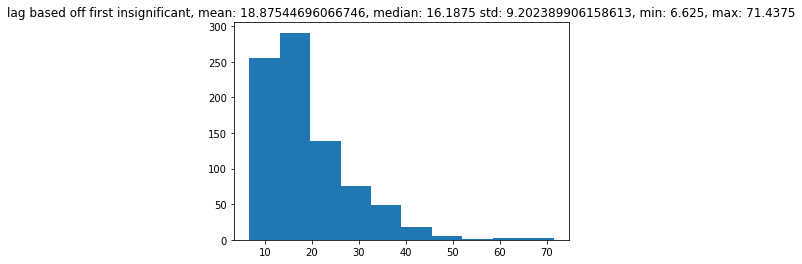

In [126]:
plt.hist(maxLags)
plt.title("lag based off first insignificant, mean: {}, median: {} std: {}, min: {}, max: {}".format(
    np.mean(maxLags), np.median(maxLags), np.std(maxLags), np.min(maxLags), np.max(maxLags)))

In [ ]:
def getACF():
    inst = np.random.choice(f["instances"].shape[0])
    dat = f["instances"][inst]
    def getVal(i,j):
        num = f["lengths"][inst]
        corr= dat[:num,i,j]
        acfVals, confint = acf(corr,
            nlags=5,
            qstat = False,
            fft=True,
            alpha=.05,
            
           )
        print(acfVals)
        print(confint)
    for i in range(16):
        for j in range(2):
            getVal(i,j)

In [ ]:
getACF()

In [ ]:
choice = np.random.choice(f["instances"].shape[0])
length = f["lengths"][choice]
dat = f["instances"][choice][:length]
for i in range(16):
    for j in range(2):
        plt.clf()
        plt.plot(dat[0:-1:5,i,j])
        plt.axhline(y=dat[0:-1:5,i,j].mean(),linestyle='-')
        plt.show()

The data looks relatively stationary

In [ ]:
choice = np.random.choice(f["instances"].shape[0])
length = f["lengths"][choice]
dat = f["instances"][choice][:length]
for i in range(16):
    for j in range(2):
        plt.clf()
        plt.plot(dat[0:15,i,j])
        plt.axhline(y=dat[0:15,i,j].mean(),linestyle='-')
        plt.show()

In [ ]:
choice = np.random.choice(f["instances"].shape[0])
(f["instances"][choice, 1:-1:5,:,:] == 0).all() and (f["instances"][choice, 2:-1:5,:,:] == 0).all() and (f["instances"][choice, 3:-1:5,:,:] == 0).all() and (f["instances"][choice, 4:-1:5,:,:] == 0).all()